In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import os
import pathlib

In [2]:
np.random.seed(0)
torch.random.manual_seed(0)
torch.cuda.manual_seed(0)

In [3]:
data_path = '../data/TSLA.csv'
data = pd.read_csv(data_path)

In [4]:
def plot_df(df, x_col, y_col, rotate=False, rotation=0, ha=''):
    ax = df.plot(x=x_col, y=y_col)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if rotate:
        plt.xticks(rotation=rotation, ha=ha)

In [5]:
def get_split(df, num_X_cols, test_ratio=0.2):
    num_train_samples = int((1-test_ratio)*df.shape[0])

    X_train = df.iloc[:num_train_samples, :num_X_cols]
    Y_train = df.iloc[:num_train_samples, num_X_cols:]
    X_test = df.iloc[num_train_samples:, :num_X_cols]
    Y_test = df.iloc[num_train_samples:, num_X_cols:]
    
    # rename columns
    for i in range(X_train.shape[1]):
        X_train.columns.values[i] = i
        X_test.columns.values[i] = i
    for i in range(Y_train.shape[1]):
        Y_train.columns.values[i] = i
        Y_test.columns.values[i] = i

    return X_train, Y_train, X_test, Y_test

def scale_data(X_train, Y_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # fit to training data (transform it as well)
    X_test_scaled = scaler.transform(X_test)        # transform test (acc. to train)
    Y_train_scaled = scaler.fit_transform(Y_train)
    return X_train_scaled, Y_train_scaled, X_test_scaled, scaler

# https://stackoverflow.com/questions/20410312/
# lagged data structure (sliding window)
in_days = 5                             # take data for in_days
out_days = 1                            # output predictions for out_days
num_cols = in_days+out_days
num_X_cols = in_days
lagged_data = pd.concat([data['Adj Close'].shift(i) for i in range(num_cols,0,-1)], axis=1).dropna()

test_ratio = 0.2
X_train, Y_train, X_test, Y_test = get_split(lagged_data, num_X_cols, test_ratio)
X_train, Y_train, X_test, scaler = scale_data(X_train, Y_train, X_test)
Y_test = Y_test.to_numpy()      # obviously, Y_test is not 'available' to be scaled...
                                # instead, predictions are inverse transformed

num_features = 1
X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], num_features))
X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], num_features))

print(f"Train: X:{X_train.shape}, Y:{Y_train.shape}\nTest: X:{X_test.shape}, Y:{Y_test.shape}")
print(type(X_train))

Train: X:(2512, 5, 1), Y:(2512, 1)
Test: X:(628, 5, 1), Y:(628, 1)
<class 'numpy.ndarray'>


In [6]:
batch_sz = 1024      # smaller batch size might help regularizing

train_loader_kwargs = {
    'batch_size': batch_sz
}
train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train),torch.Tensor(Y_train)), **train_loader_kwargs
)

test_loader_kwargs = {
    'batch_size': batch_sz
}
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test),torch.Tensor(Y_test)), **test_loader_kwargs
)

In [7]:
for inputs, labels in train_loader:
    print(inputs.shape)     # (batch size, sequence length, input dimension)
    print(labels.shape)
    break

torch.Size([1024, 5, 1])
torch.Size([1024, 1])


In [8]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, sequence_length, dropout=0):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(in_features=hidden_size*sequence_length, out_features=output_size)
        
        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0.01)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, (hn, cn) = self.lstm(x, (h0, c0))      # out: (batch size, sequence length, input dims)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out

In [9]:
# paste from relevant in=in_days_out=out_days/args.txt

model_args = {
    'input_size': 1,
    'output_size': out_days,
    'hidden_size': 128,
    'num_layers': 1,
    'sequence_length': num_X_cols,       # = in_days
}
model = StockLSTM(**model_args)
optim_args = {
    'lr': 1e-4
}
optimizer = torch.optim.RMSprop(model.parameters(), **optim_args)
loss_fn = nn.MSELoss()

In [10]:
def train(num_epochs):
    dict_losses = {}
    print_width = max(1, num_epochs/10)

    for epoch in range(num_epochs):
        train_loss = 0

        model.train()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)

            # print(outputs.shape, labels.shape)
            assert outputs.shape==labels.shape                  # useful check

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        dict_losses[epoch] = train_loss

        if epoch%print_width==0:
            print("Epoch:", epoch, "\tLoss:", train_loss)
        
    return dict_losses

In [11]:
dict_losses = train(200)

Epoch: 0 	Loss: 0.17535618972033262
Epoch: 20 	Loss: 0.062000041361898184
Epoch: 40 	Loss: 0.04227272071875632
Epoch: 60 	Loss: 0.024590369954239577
Epoch: 80 	Loss: 0.010782991826999933
Epoch: 100 	Loss: 0.003693274178658612
Epoch: 120 	Loss: 0.0020546024024952203
Epoch: 140 	Loss: 0.0019105629544355907
Epoch: 160 	Loss: 0.0018763413318083622
Epoch: 180 	Loss: 0.0018433509831083938


In [12]:
results_main = '../results/lstm/'
pathlib.Path(results_main).mkdir(exist_ok=True, parents=True)

results_in_out = os.path.join(results_main, f'in={in_days}_out={out_days}')
pathlib.Path(results_in_out).mkdir(exist_ok=True, parents=True)

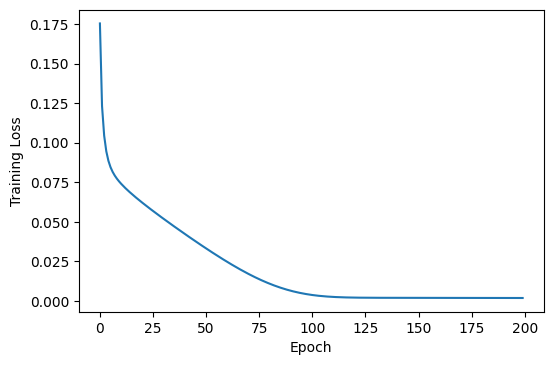

In [13]:
plt.plot(dict_losses.keys(), dict_losses.values())
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

fig = plt.gcf()
fig.set_size_inches(6,4)
fig.set_dpi(100)

plt.savefig(os.path.join(results_in_out,'loss.png'), bbox_inches='tight', facecolor="w")

In [14]:
def predict(model, loader, inverse_transform=False, scaler=None):
    preds = []
    with torch.no_grad():               # not training, so no need to calculate gradients
        for inputs, labels in loader:
            outputs = model(inputs)
            preds.append(outputs)
    preds = torch.cat(preds, axis=0).numpy()
    if inverse_transform:
        preds = scaler.inverse_transform(preds)
    return preds

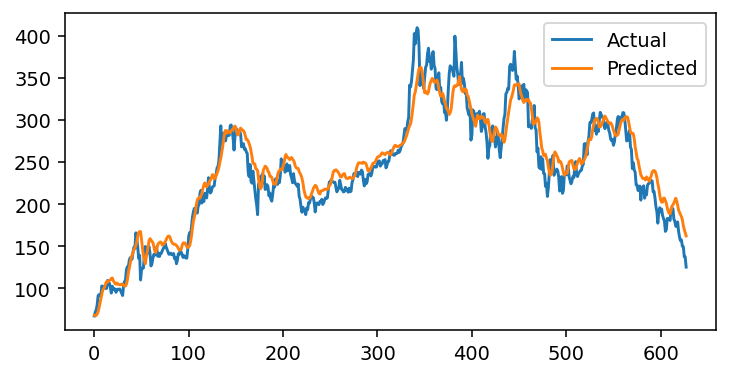

In [15]:
preds_test = predict(model, test_loader, inverse_transform=True, scaler=scaler)

actual_and_pred = pd.DataFrame(columns=['Actual','Predicted'])
actual_and_pred['Actual'] = Y_test[:,0]
actual_and_pred['Predicted'] = preds_test[:,0]

fig = plt.figure(figsize=(6,3), dpi=140)
actual_and_pred.plot(ax=plt.gca())
plt.savefig(os.path.join(results_in_out,'test.png'), bbox_inches='tight', facecolor="w")

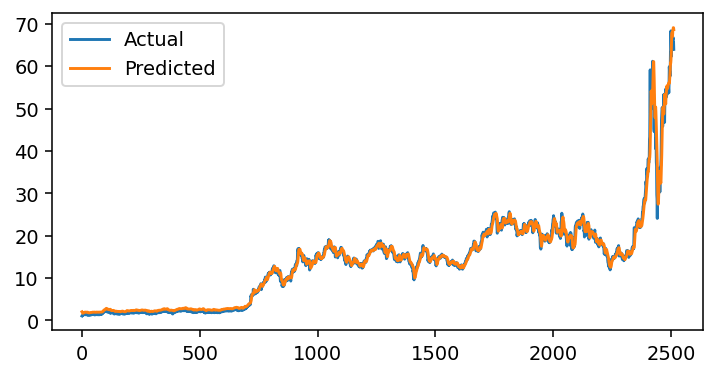

In [16]:
preds_train = predict(model, train_loader, inverse_transform=True, scaler=scaler)
train_Y_df = pd.DataFrame(columns=['Actual', 'Predicted'])
train_Y_df['Actual'] = (scaler.inverse_transform(Y_train))[:,0]
train_Y_df['Predicted'] = preds_train[:,0]

fig = plt.figure(figsize=(6,3), dpi=140)
train_Y_df.plot(ax=plt.gca())
plt.savefig(os.path.join(results_in_out,'train.png'), bbox_inches='tight', facecolor="w")
                                                                                    # facecolor: jupyter problem
                                                                                    # https://stackoverflow.com/questions/52371499